In [1]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.models import resnet50
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv(r"C:\Users\HP\Desktop\meme_project\meme_1.csv").dropna()

In [3]:
class_weights = compute_class_weight('balanced', classes=np.unique(df['label']), y=df['label'])
class_weights = torch.tensor(class_weights, dtype=torch.float)

In [4]:
tokenizer = AutoTokenizer.from_pretrained("ai4bharat/IndicBERTv2-MLM-only")
text_model = AutoModel.from_pretrained("ai4bharat/IndicBERTv2-MLM-only")
for param in text_model.parameters():
    param.requires_grad = False

In [5]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor()
])

In [6]:
image_model = resnet50(pretrained=True)
image_model = nn.Sequential(*list(image_model.children())[:-1])
for param in image_model.parameters():
    param.requires_grad = True

C:\Users\HP\anaconda3\envs\tf38\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\HP\anaconda3\envs\tf38\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
class MemeDataset(Dataset):
    def __init__(self, df, image_folder):
        self.df = df
        self.image_folder = image_folder

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_path = os.path.join(self.image_folder, row['image'])
        image = Image.open(image_path).convert('RGB')
        image_tensor = transform(image)

        inputs = tokenizer(row['text'], return_tensors="pt", truncation=True, padding=True)
        text_emb = text_model(**inputs).last_hidden_state.mean(dim=1).squeeze()

        image_emb = image_model(image_tensor.unsqueeze(0)).squeeze()
        label = torch.tensor(row['label'], dtype=torch.long)
        return torch.cat((image_emb, text_emb), dim=0), label

In [8]:
image_folder = r"C:\Users\HP\Desktop\MEME"

In [9]:
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)
train_dataset = MemeDataset(train_df, image_folder)
test_dataset = MemeDataset(test_df, image_folder)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4)

In [10]:
class MultiModalClassifier(nn.Module):
    def __init__(self):
        super(MultiModalClassifier, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(2048 + 768, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 2)
        )

    def forward(self, x):
        return self.classifier(x)

In [11]:
model = MultiModalClassifier()
criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.1)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [12]:
loss_history = []
lr_history = []

for epoch in range(20):
    model.train()
    total_loss = 0
    for inputs, labels in train_loader:
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        lr_history.append(optimizer.param_groups[0]['lr'])

    loss_history.append(total_loss)
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Epoch 1, Loss: 20.0966
Epoch 2, Loss: 20.2961
Epoch 3, Loss: 20.1567
Epoch 4, Loss: 19.7168
Epoch 5, Loss: 19.7920
Epoch 6, Loss: 19.5195
Epoch 7, Loss: 19.7835
Epoch 8, Loss: 19.5911
Epoch 9, Loss: 20.0637
Epoch 10, Loss: 19.5930
Epoch 11, Loss: 20.1367
Epoch 12, Loss: 19.0241
Epoch 13, Loss: 19.6005
Epoch 14, Loss: 19.7244
Epoch 15, Loss: 20.3062
Epoch 16, Loss: 19.9739
Epoch 17, Loss: 19.2686
Epoch 18, Loss: 19.4576
Epoch 19, Loss: 19.1467
Epoch 20, Loss: 19.1287


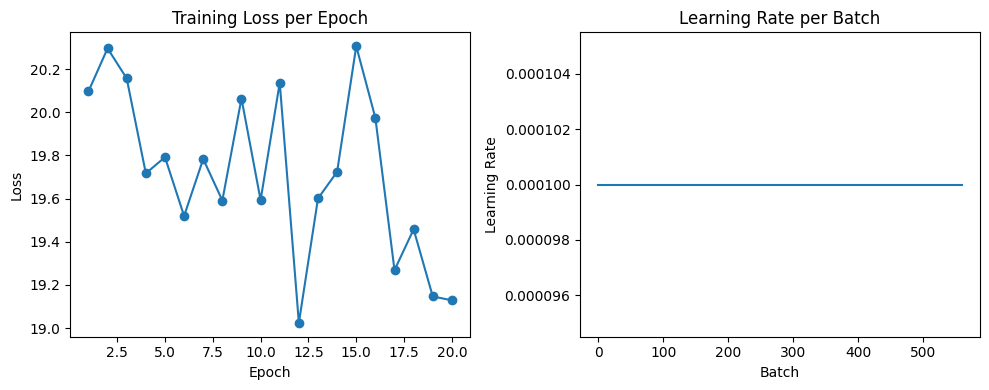

In [13]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(loss_history)+1), loss_history, marker='o')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(lr_history)
plt.title('Learning Rate per Batch')
plt.xlabel('Batch')
plt.ylabel('Learning Rate')
plt.tight_layout()
plt.show()

In [14]:
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.tolist())
        all_labels.extend(labels.tolist())

print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

           0       0.71      0.94      0.81        18
           1       0.75      0.30      0.43        10

    accuracy                           0.71        28
   macro avg       0.73      0.62      0.62        28
weighted avg       0.72      0.71      0.67        28



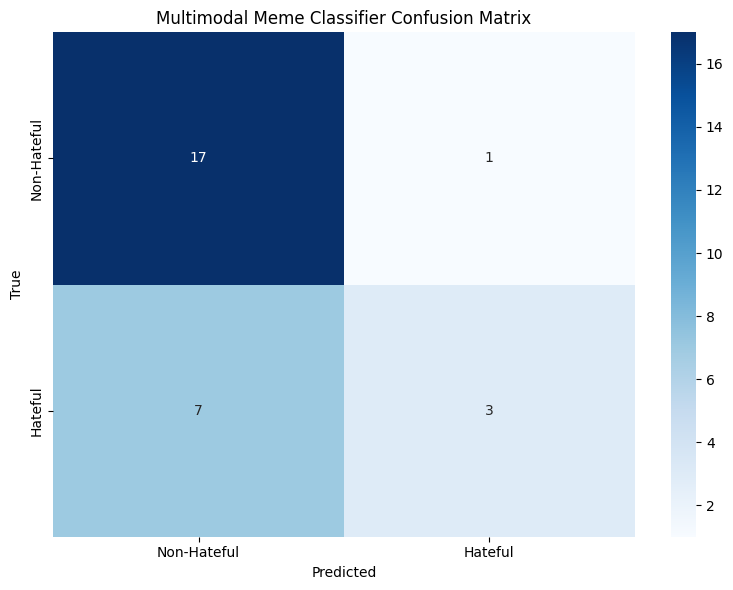

In [15]:
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(all_labels, all_preds), annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Hateful', 'Hateful'], yticklabels=['Non-Hateful', 'Hateful'])
plt.title("Multimodal Meme Classifier Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()